In [1]:
import os
import numpy as np
import awkward as ak
from argparse import ArgumentParser

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"  # "3"
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from general import feat, table_to_numpy, accuracy_max, TitledModel, plot_loss_history, HDF5File

2024-07-23 15:08:04.399910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_data(path, *args):
    with HDF5File(path, "r") as f:
        data = f["data"]
        offset = f["offset"]
        scale = f["scale"]
    flav = data["jet_flav"] * scale["jet_flav"] + offset["jet_flav"]
    data["jet_flav"] = ak.values_astype(flav + 0.5 * np.sign(flav), int)
    data = data[(ak.sum(data["jet_flav"] == 5, axis=1) == 1) & (ak.sum(data["jet_flav"] == -5, axis=1) == 1)]
    data["weight"] = data["weight"] * scale["weight"] + offset["weight"]

    flav = np.asarray(ak.fill_none(ak.pad_none(data["jet_flav"], ak.max(ak.num(data["jet_flav"]))), 0))
    label = ((flav == 5)[:, :, None] & (flav == -5)[:, None, :]).astype(float).reshape((-1, flav.shape[1] ** 2))
    weight = abs(np.asarray(data["weight"]))
    data = [table_to_numpy(data, arg) for arg in args]
    return data, label, [weight]*len(label) if isinstance(label, list) else weight


def make_model(input_shapes, input_titles, num_layers_per_input, num_layers, num_nodes, activation, dropout,
               num_outputs, output_titles, lr, decay):
    if not isinstance(activation, (list, tuple)):
        activation = [activation]
    if not isinstance(num_nodes, (list, tuple)):
        num_nodes = [num_nodes]

    inputs = []
    for input_shape in input_shapes:
        inputs.append(keras.Input(shape=input_shape[1:]))
    xs = []
    for i, num_layer_input in enumerate(num_layers_per_input):
        x = inputs[i]
        for j in range(num_layer_input):
            act = activation[j % len(activation)]
            nn = num_nodes[j % len(num_nodes)]
            x = keras.layers.Dense(nn, activation=act)(x)
            if dropout:
                x = keras.layers.Dropout(dropout)(x)
        if len(inputs[i].shape) == 3:
            x = keras.layers.Flatten()(x)
        xs.append(x)
    x = keras.layers.Concatenate()(xs)

    for i in range(num_layers):
        act = activation[i % len(activation)]
        nn = num_nodes[i % len(num_nodes)]
        x = keras.layers.Dense(nn, activation=act)(x)
        if dropout:
            x = keras.layers.Dropout(dropout)(x)
    if num_outputs == 1:
        cls_activation = "sigmoid"
        loss = "binary_crossentropy"
    else:
        cls_activation = "softmax"
        loss = "categorical_crossentropy"
    cls = keras.layers.Dense(num_outputs, activation=cls_activation, name="cls")(x)
    model = TitledModel(inputs=inputs, outputs=[cls], input_titles=input_titles, output_titles=output_titles)
    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=decay),
        metrics=[],
        weighted_metrics=[accuracy_max]
    )

    return model


def load_normalization(path):
    with HDF5File(path, "r") as f:
        return ak.to_list(f["offset"])[0], ak.to_list(f["scale"])[0]    

In [3]:
path       = '/nfs/dust/cms/user/stafford/For_Emanuele/reconn/skims/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/'
train_file = path + 'traindata.hdf5'
valid_file = path + 'validatedata.hdf5'

In [4]:
features1 = feat("jet") + ["jet_btag"]
features2 = feat("alep") + feat("lep") + ["met_pt", "met_phi", "met_x", "met_y"]
train    = load_data(train_file, features1, features2)
validate = load_data(valid_file, features1, features2)
model = make_model(
    [t.shape for t in train[0]],  # Input shapes
    [features1, features2],       # Input titles
    [2, 0],                       # Number of layers per input
    2,                            # Number of layers after concatenation
    200,                          # Number of nodes per layer
    "relu",                       # Activation function
    0.25,                         # Dropout rate
    train[1].shape[1],            # Number of outputs
    [],                           # Output titles
    0.0003,                       # Learning rate
    0                             # Learning rate decay
)
print(f"Got {train[0][0].shape[0]} events, {train[0][0].shape[1]} jets and {train[1].shape[1]} outputs")
earlystop = keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", mode="min")
checkpoint = keras.callbacks.ModelCheckpoint("model_bcls_test.hdf5", save_best_only=True, verbose=1)

epochs = 3
batch_size = 2**13

Got 558595 events, 7 jets and 49 outputs


In [5]:
model.summary()

Model: "titled_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 9)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 7, 200)       2000        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 7, 200)       0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 7, 200)       40200       ['dropout[0][0]']                
                                                                                       

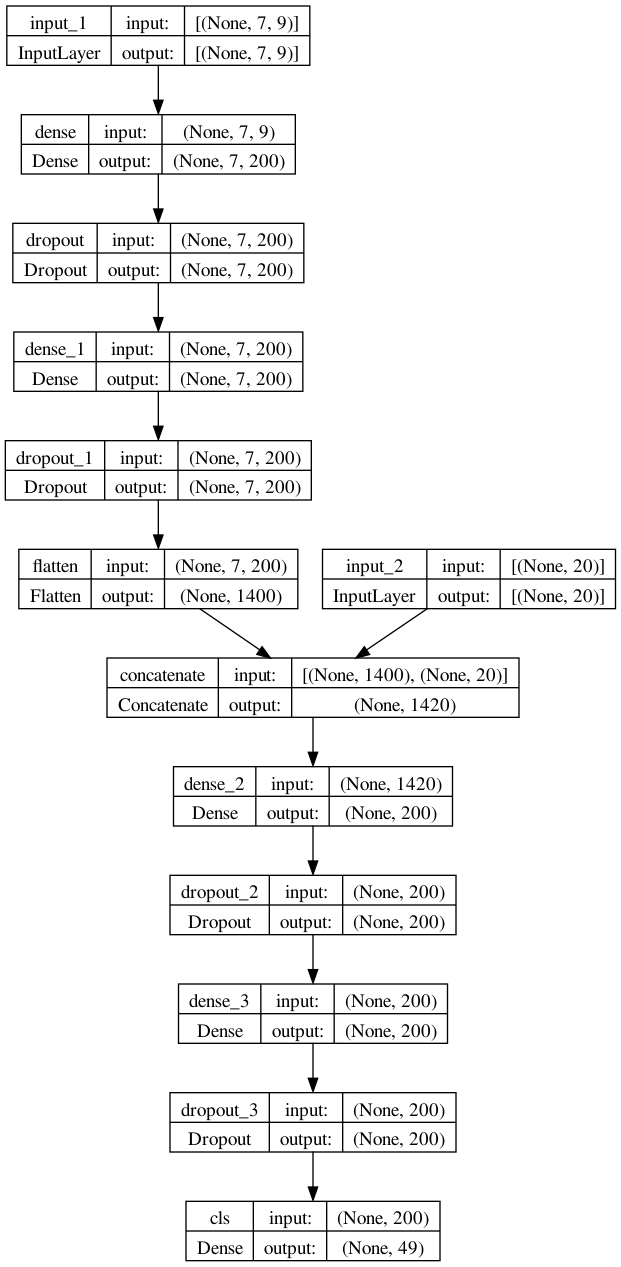

In [6]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [13]:
len(train[0])

2

In [14]:
len(train[1])

558595

In [15]:
len(train[2])

558595

In [20]:
train[0][0].shape

(558595, 7, 9)

In [19]:
train[0][1].shape

(558595, 20)

In [18]:
train[0][0][0]

array([[-4.52201872e-01,  1.50639246e+00, -6.22060073e-01,
         9.10862986e-02,  5.29333514e-01,  1.02582160e+00,
        -7.41750951e-01,  4.66807420e-01,  1.33042896e+00],
       [-3.24177767e-02, -1.40686990e+00, -1.33269870e-03,
        -3.02652932e-01,  3.46008243e-01, -8.79548855e-01,
        -2.74340079e-03,  3.55075131e-01, -7.90526813e-01],
       [-3.57231323e-01,  1.32031519e-01,  1.28132777e-01,
        -7.37409760e-01, -8.12069177e-01,  1.53834596e+00,
         6.45113390e-01, -6.33034677e-01, -8.03454273e-01],
       [-1.23649502e-01, -3.22931555e-01,  7.59261920e-02,
        -7.87996476e-01, -8.51134046e-01, -1.07104000e+00,
         4.43143841e-01, -7.63304547e-01, -9.50131221e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.000000

In [7]:
history = model.fit(
    train[0], train[1], sample_weight=train[2], batch_size=batch_size,
    epochs=epochs, validation_data=validate,
    callbacks=[earlystop, checkpoint])

2024-07-23 15:09:00.791369: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 140765940 exceeds 10% of free system memory.
2024-07-23 15:09:00.912075: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 109484620 exceeds 10% of free system memory.


Epoch 1/3
69/69 [==============================] - ETA: 0s - loss: 0.1748 - accuracy_max: 0.3313

2024-07-23 15:11:49.635541: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 60329304 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.09755, saving model to model_bcls_test.hdf5
69/69 [==============================] - 86s 1s/step - loss: 0.1748 - accuracy_max: 0.3313 - val_loss: 0.0975 - val_accuracy_max: 0.4813
Epoch 2/3
69/69 [==============================] - ETA: 0s - loss: 0.0950 - accuracy_max: 0.4543
Epoch 2: val_loss improved from 0.09755 to 0.07800, saving model to model_bcls_test.hdf5
69/69 [==============================] - 25s 359ms/step - loss: 0.0950 - accuracy_max: 0.4543 - val_loss: 0.0780 - val_accuracy_max: 0.5355
Epoch 3/3
69/69 [==============================] - ETA: 0s - loss: 0.0825 - accuracy_max: 0.5058
Epoch 3: val_loss improved from 0.07800 to 0.07038, saving model to model_bcls_test.hdf5
69/69 [==============================] - 31s 448ms/step - loss: 0.0825 - accuracy_max: 0.5058 - val_loss: 0.0704 - val_accuracy_max: 0.5996


In [9]:
plot_loss_history(history, "loss_tt.svg")